In [1]:
import os, random, gc
from pathlib import Path

SEED = 42

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from torch.utils.data import Dataset, ConcatDataset
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
PROJECT_NAME = "Assignment-01"
DELETE_EXISTING_DATASETS = True

In [3]:
BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "models"
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

In [4]:
def set_seeds(seed: int):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(SEED)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(SEED)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

All random seeds set to 42 for reproducibility


In [5]:
dataset_names = {
        "train-val": "mnist-train-val-set",
        "train": "mnist-train-set",
        "validation": "mnist-validation-set",
        "test": "mnist-test-set"
    }

if DELETE_EXISTING_DATASETS:
    for dataset_name in dataset_names.values():
        if dataset_name in fo.list_datasets():
            print(f"Dataset '{dataset_name}' already exists. Deleting it.")
            fo.delete_dataset(dataset_name)

Dataset 'mnist-train-val-set' already exists. Deleting it.
Dataset 'mnist-test-set' already exists. Deleting it.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preparation

In [7]:
# Get Train-Val Dataset
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name=dataset_names["train-val"],
                                         persistent=True)

train_val_dataset.compute_metadata()

Split 'train' already downloaded
Loading 'mnist' split 'train'
 100% |█████████████| 60000/60000 [25.4s elapsed, 0s remaining, 2.6K samples/s]      
Dataset 'mnist-train-val-set' created
Computing metadata...
 100% |█████████████| 60000/60000 [24.0s elapsed, 0s remaining, 12.8K samples/s]      


In [8]:
train_val_dataset.untag_samples(["train", "validation"])

# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=SEED)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print("Tag counts after split:")
print(tag_counts)

# Separate validation and train FO datasets
train_dataset = train_val_dataset.match_tags("train").clone()
val_dataset = train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
train_dataset.name = dataset_names["train"]
val_dataset.name = dataset_names["validation"]

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)

Tag counts after split:
{'train': 51000, 'validation': 9000}


In [9]:
# Get Test Dataset
test_dataset = foz.load_zoo_dataset(
    "mnist",
    split="test",
    dataset_name=dataset_names["test"],
    persistent=True
)

test_dataset.compute_metadata()

Split 'test' already downloaded
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [4.1s elapsed, 0s remaining, 2.1K samples/s]      
Dataset 'mnist-test-set' created
Computing metadata...
 100% |█████████████| 10000/10000 [4.0s elapsed, 0s remaining, 7.1K samples/s]      


In [10]:
# Get Label Map
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [11]:
# Custom PyTorch Dataset class for MNIST training data
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms

        if label_map is None:
            self.label_map = {str(i): i for i in range(10)}
        else:
            self.label_map = label_map

        print(f"CustomTorchImageDataset initialized with {len(self.image_paths)} samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L') # Convert to grayscale
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(1, 28, 28), torch.tensor(-1, dtype=torch.long)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        if label_idx == -1:
            print(f"Warning: Label '{label_str}' not in label_map for image {image_path}")

        return image, torch.tensor(label_idx, dtype=torch.long)

In [12]:
# Define image transformations
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), # Scale to [0, 1]
])

In [13]:
# Create a PyTorch Dataset for the train set
torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=image_transforms)

CustomTorchImageDataset initialized with 51000 samples.


In [14]:
# Create a PyTorch Dataset for the validation set
torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

CustomTorchImageDataset initialized with 9000 samples.


In [15]:
# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(test_dataset,
                                      label_map=label_map,
                                      image_transforms=image_transforms)

CustomTorchImageDataset initialized with 10000 samples.


In [16]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 32
num_workers = 0 # We use GPU, so we set num_workers to 0

In [17]:
# Create a PyTorch DataLoader for the train set
train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)
print("Train DataLoader created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")

# Create a PyTorch DataLoader for the validation set
val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
print("Validation DataLoader created successfully.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_loader)} batches.")


Train DataLoader created successfully.
Train DataLoader has 797 batches.
Validation DataLoader created successfully.
Validation DataLoader has 282 batches.
Test DataLoader created successfully.
Test DataLoader has 313 batches.


# Model Definition

In [18]:
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [25]:
model = ModernLeNet5().to(device)

ce_loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)

In [26]:
def train_epoch(model, train_loader):
  batch_losses = []
  correct = 0
  total = 0

  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())
      preds = logits.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  train_loss = np.mean(batch_losses)
  train_acc = correct / total
  return train_loss, train_acc


In [27]:
def val_epoch(model, val_loader):
  batch_losses = []
  correct = 0
  total = 0

  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)

      batch_losses.append(loss_value.item())
      preds = logits.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  val_loss = np.mean(batch_losses)
  val_acc = correct / total
  return val_loss, val_acc

# Training

In [28]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
model_save_path = MODEL_PATH / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

Training:   0%|          | 0/797 [00:00<?, ?it/s]

Validation: 100%|██████████| 282/282 [00:07<00:00, 36.85it/s]


Epoch 1/10 - Train Loss: 0.2925 - Train Acc: 0.9114 - Val Loss: 0.0917 - Val Acc: 0.9723
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:08<00:00, 34.78it/s]


Epoch 2/10 - Train Loss: 0.0961 - Train Acc: 0.9742 - Val Loss: 0.0761 - Val Acc: 0.9777
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:07<00:00, 35.51it/s]


Epoch 3/10 - Train Loss: 0.0722 - Train Acc: 0.9800 - Val Loss: 0.0513 - Val Acc: 0.9857
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:07<00:00, 37.05it/s]


Epoch 4/10 - Train Loss: 0.0614 - Train Acc: 0.9832 - Val Loss: 0.0643 - Val Acc: 0.9854


Validation: 100%|██████████| 282/282 [00:06<00:00, 43.48it/s]


Epoch 5/10 - Train Loss: 0.0557 - Train Acc: 0.9850 - Val Loss: 0.0650 - Val Acc: 0.9821


Validation: 100%|██████████| 282/282 [00:08<00:00, 33.96it/s]


Epoch 6/10 - Train Loss: 0.0476 - Train Acc: 0.9864 - Val Loss: 0.0557 - Val Acc: 0.9861


Validation: 100%|██████████| 282/282 [00:08<00:00, 33.28it/s]


Epoch 7/10 - Train Loss: 0.0440 - Train Acc: 0.9885 - Val Loss: 0.0596 - Val Acc: 0.9859


Validation: 100%|██████████| 282/282 [00:07<00:00, 35.43it/s]


Epoch 8/10 - Train Loss: 0.0407 - Train Acc: 0.9887 - Val Loss: 0.0499 - Val Acc: 0.9883
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:07<00:00, 35.32it/s]


Epoch 9/10 - Train Loss: 0.0362 - Train Acc: 0.9901 - Val Loss: 0.0710 - Val Acc: 0.9837


Validation: 100%|██████████| 282/282 [00:08<00:00, 34.71it/s]

Epoch 10/10 - Train Loss: 0.0363 - Train Acc: 0.9899 - Val Loss: 0.0592 - Val Acc: 0.9859


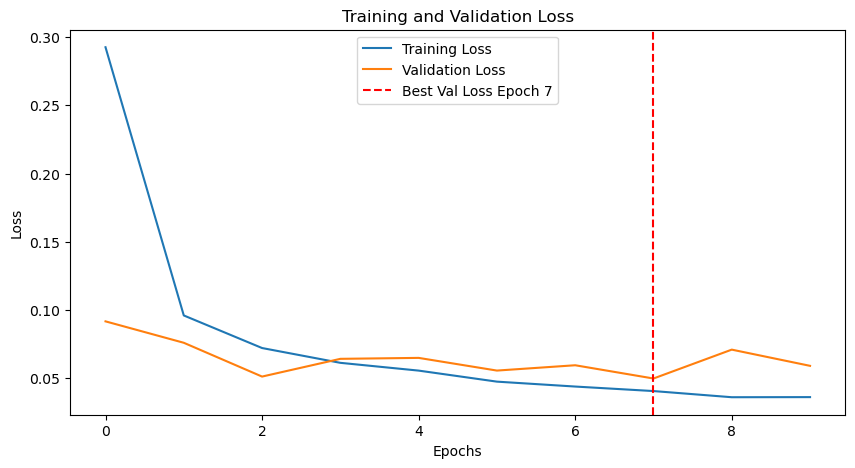

In [29]:
plt.figure(figsize=(num_epochs, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses)

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

# Evaluate on the Test Set

In [30]:
# Define the path where the best model was saved
model_save_path = MODEL_PATH / 'best_lenet.pth'

# Instantiate a new model with the same architecture
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /sc/home/josef.pribbernow/HPI-Applied-Hands-On-Computer-Vision-2025-Josef-Pribbernow/Assignment-01/models/best_lenet.pth
Model is on device: cuda:0


In [31]:
session = fo.launch_app(test_dataset, auto=False, port=8080)


Could not connect session, trying again in 10 seconds

Session launched. Run `session.show()` to open the App in a cell output.


In [32]:
## Apply best_model to the test set, store logits and confidence

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits
predictions = []
all_logits = []

# Run inference on the test set
print("Applying best LeNet model to the test set...")
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

print("Inference on test set complete.")
print(f"Shape of collected logits: {all_logits.shape}")
print(f"Number of collected predictions: {len(predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(test_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()

Applying best LeNet model to the test set...


100%|██████████| 313/313 [00:09<00:00, 33.61it/s]


Inference on test set complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...


In [33]:
print("\n=== Verification ===")
sample = test_dataset.first()
print(f"Sample prediction type: {type(sample.lenet_classification)}")
print(f"Sample prediction: {sample.lenet_classification}")
print(f"Prediction label: {sample.lenet_classification.label}")
print(f"Prediction confidence: {sample.lenet_classification.confidence}")
print(f"Prediction logits shape: {len(sample.lenet_classification.logits)}")

session.refresh()
print(f"\nFiftyOne App URL: {session.url}")




=== Verification ===
Sample prediction type: <class 'fiftyone.core.labels.Classification'>
Sample prediction: <Classification: {
    'id': '68fcd2648c979d6a364d2b42',
    'tags': [],
    'label': '7 - seven',
    'confidence': 1.0,
    'logits': array([-21.94848251,  -9.32775211,  -8.4161377 ,  -8.04616547,
           -11.33539581, -14.42301083, -36.03982544,  20.07966042,
           -17.42926788,  -5.4287219 ]),
}>
Prediction label: 7 - seven
Prediction confidence: 1.0
Prediction logits shape: 10

FiftyOne App URL: http://localhost:8080/


In [34]:
# Create a view showing only LeNet's misclassifications
misclassified_view = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")

session.view = misclassified_view
session.refresh()

Misclassified samples: 107 samples


In [35]:
lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.987     0.995     0.991       980
     1 - one      0.990     0.995     0.993      1135
     2 - two      0.985     0.986     0.986      1032
   3 - three      0.990     0.988     0.989      1010
    4 - four      0.992     0.986     0.989       982
    5 - five      0.989     0.990     0.989       892
     6 - six      0.994     0.986     0.990       958
   7 - seven      0.989     0.991     0.990      1028
   8 - eight      0.989     0.993     0.991       974
    9 - nine      0.988     0.982     0.985      1009

    accuracy                          0.989     10000
   macro avg      0.989     0.989     0.989     10000
weighted avg      0.989     0.989     0.989     10000



In [36]:
# Compute quantiles of confidence
test_dataset.quantiles("lenet_classification.confidence", [0.01, 0.05, 0.25, 0.5, 0.75] )

[0.8013332486152649, 0.9974998831748962, 0.9999997615814209, 1.0, 1.0]

In [37]:
low_confidence_view = test_dataset.match(F("lenet_classification.confidence") < 0.69)
session.view = low_confidence_view
session.refresh()

In [38]:
#Hardness is a measure computed based on model prediction output (through
#logits) that summarizes a measure of the uncertainty the model had with the
#sample. This makes hardness quantitative and can be used to detect things
#like hard samples and annotation errors
fob.compute_hardness(test_dataset,
                     label_field='lenet_classification',
                     )

Computing hardness...
   0% ||------------|     0/10000 [2.1ms elapsed, ? remaining, ? samples/s] 

 100% |█████████████| 10000/10000 [12.3s elapsed, 0s remaining, 831.0 samples/s]      
Hardness computation complete


In [39]:
# Evaluate sample mistakenness (how likely the sample is mislabeled)
# Samples with high mistakenness often have conflicting model output and ground truth
fob.compute_mistakenness(test_dataset,
                         pred_field="lenet_classification",
                         label_field="ground_truth")


Computing mistakenness...
 100% |█████████████| 10000/10000 [10.7s elapsed, 0s remaining, 950.9 samples/s]      
Mistakenness computation complete


In [40]:
# Compute quantiles of mistakenness
mistakenness_quantiles = test_dataset.quantiles(
    "mistakenness",
    [0.9, 0.95, 0.99]
)

print("\nMistakenness quantiles for train_dataset:")
print(mistakenness_quantiles)



Mistakenness quantiles for train_dataset:
[3.7610530853271484e-05, 0.0013419091701507568, 0.731199786067009]


In [41]:
suspicious_test_samples_view = test_dataset.match(
                             F("mistakenness") > mistakenness_quantiles[-1]
                             ).sort_by("mistakenness", reverse=True)

# Set the session view to one of the views to visualize it in the App
session.view = suspicious_test_samples_view
session.refresh()